# Import required libraries

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=38334 sha256=01946e94740e9c20b8b777f820ba4325cf9c817ecb099a51c516d9e4977d6834
  Stored in directory: /root/.cache/pip/wheels/b4/68/bb/d10381e86dc0de1c9354bce3d86bffcd247305058c40ce2e55
Successfully built grad-cam


In [65]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.models import densenet169

# Set random seed for reproducibility

In [4]:
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Download and extract the dataset

In [4]:
!wget -O FETAL_PLANES_ZENODO.zip https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1
!unzip FETAL_PLANES_ZENODO.zip -d fetal_planes_zenodo

--2024-07-18 22:45:16--  https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3904280/files/FETAL_PLANES_ZENODO.zip [following]
--2024-07-18 22:45:17--  https://zenodo.org/records/3904280/files/FETAL_PLANES_ZENODO.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2088522169 (1.9G) [application/octet-stream]
Saving to: 'FETAL_PLANES_ZENODO.zip'

FETAL_PLANES_ZENODO 100%[===================>]   1.94G  20.0MB/s    in 1m 46s  

2024-07-18 22:47:03 (18.7 MB/s) - 'FETAL_PLANES_ZENODO.zip' saved [2088522169/2088522169]

Archive:  FETAL_PLANES_ZENODO.zip
  inflating: fetal_planes_zenodo/FETAL_PLANES_DB_data.csv  
  inflating: fetal_planes_zenodo/FETAL_PLANES_DB_data.xlsx  
   cr

In [6]:
dataset_zip_path = '/kaggle/working/FETAL_PLANES_ZENODO.zip'
if os.path.exists(dataset_zip_path):
    os.remove(dataset_zip_path)

# Load the CSV file

In [9]:
df = pd.read_csv('/kaggle/working/fetal_planes_zenodo/FETAL_PLANES_DB_data.csv', delimiter=';')
df = df.rename(columns={'Train ': 'Train'})

# Display the first few rows and basic information about the dataset

In [10]:
print(df.head())
print(df.info())

                    Image_name  Patient_num  Plane  Brain_plane Operator  \
0  Patient00001_Plane1_1_of_15            1  Other  Not A Brain    Other   
1  Patient00001_Plane1_2_of_15            1  Other  Not A Brain    Other   
2  Patient00001_Plane1_3_of_15            1  Other  Not A Brain    Other   
3  Patient00001_Plane1_4_of_15            1  Other  Not A Brain    Other   
4  Patient00001_Plane1_5_of_15            1  Other  Not A Brain    Other   

  US_Machine  Train  
0      Aloka      1  
1      Aloka      1  
2      Aloka      1  
3      Aloka      1  
4      Aloka      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image_name   12400 non-null  object
 1   Patient_num  12400 non-null  int64 
 2   Plane        12400 non-null  object
 3   Brain_plane  12400 non-null  object
 4   Operator     12400 non-null  object
 5   US_Machine 

# Display class distribution

In [11]:
print("\nClass Distribution:")
print(df['Plane'].value_counts(normalize=True))


Class Distribution:
Plane
Other              0.339758
Fetal brain        0.249355
Fetal thorax       0.138548
Maternal cervix    0.131129
Fetal femur        0.083871
Fetal abdomen      0.057339
Name: proportion, dtype: float64


# Display the distribution of brain subclasses

In [12]:
print("\nBrain Subclass Distribution:")
print(df['Brain_plane'].value_counts(normalize=True))


Brain Subclass Distribution:
Brain_plane
Not A Brain          0.750645
Trans-thalamic       0.132097
Trans-cerebellum     0.057581
Trans-ventricular    0.048145
Other                0.011532
Name: proportion, dtype: float64


# Set the path for the image directory

In [13]:
image_dir = '/kaggle/working/fetal_planes_zenodo/Images'

# Data Preparation and Custom Dataset

In [14]:
class FetalPlanesDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.copy()
        self.img_dir = img_dir
        self.transform = transform
        
        self.label_encoder = LabelEncoder()
        self.dataframe['Plane_encoded'] = self.label_encoder.fit_transform(self.dataframe['Plane'])
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image_name'] + '.png'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')
        
        label = self.dataframe.iloc[idx]['Plane_encoded']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Split the data into train and test sets

In [16]:
train_df = df[df['Train'] == 1]
test_df = df[df['Train'] == 0]

# Create datasets

In [17]:
train_dataset = FetalPlanesDataset(train_df, image_dir, transform=train_transform)
test_dataset = FetalPlanesDataset(test_df, image_dir, transform=test_transform)

In [18]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 7129
Number of test samples: 5271


# Weighted sampler for handling class imbalance

In [19]:
class_counts = Counter(train_dataset.dataframe['Plane_encoded'])
class_weights = {class_id: 1.0 / count for class_id, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_dataset.dataframe['Plane_encoded']]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

# Create data loaders

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Verify data loading

In [21]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Batch shape: torch.Size([32, 1, 224, 224])
Labels shape: torch.Size([32])


# Model Architecture

In [60]:
class FetalPlanesModel(nn.Module):
    def __init__(self, num_classes):
        super(FetalPlanesModel, self).__init__()
        
        self.densenet = densenet169(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.densenet(x)

In [23]:
num_classes = len(train_dataset.label_encoder.classes_)
model = FetalPlanesModel(num_classes).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 121MB/s] 


# Weighted loss

In [24]:
class_counts = Counter(train_dataset.dataframe['Plane_encoded'])
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

# Training and Evaluation Functions

In [25]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [26]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training Loop

In [42]:
num_epochs = 50
best_acc = 0.0

In [43]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    
    scheduler.step(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print()

print(f"Best Validation Accuracy: {best_acc:.4f}")

Epoch 1/50
Train Loss: 0.4441, Train Acc: 0.7622
Val Loss: 0.3960, Val Acc: 0.7752

Epoch 2/50
Train Loss: 0.1450, Train Acc: 0.9175
Val Loss: 0.3913, Val Acc: 0.7866

Epoch 3/50
Train Loss: 0.0898, Train Acc: 0.9428
Val Loss: 0.2338, Val Acc: 0.8771

Epoch 4/50
Train Loss: 0.0967, Train Acc: 0.9425
Val Loss: 0.2598, Val Acc: 0.8680

Epoch 5/50
Train Loss: 0.0715, Train Acc: 0.9551
Val Loss: 0.2344, Val Acc: 0.8886

Epoch 6/50
Train Loss: 0.0602, Train Acc: 0.9642
Val Loss: 0.2326, Val Acc: 0.8945

Epoch 7/50
Train Loss: 0.0777, Train Acc: 0.9540
Val Loss: 0.1912, Val Acc: 0.8994

Epoch 8/50
Train Loss: 0.0510, Train Acc: 0.9687
Val Loss: 0.2588, Val Acc: 0.8788

Epoch 9/50
Train Loss: 0.0551, Train Acc: 0.9640
Val Loss: 0.2055, Val Acc: 0.8989

Epoch 10/50
Train Loss: 0.0532, Train Acc: 0.9666
Val Loss: 0.2237, Val Acc: 0.8856

Epoch 11/50
Train Loss: 0.0472, Train Acc: 0.9697
Val Loss: 0.1563, Val Acc: 0.9270

Epoch 12/50
Train Loss: 0.0382, Train Acc: 0.9753
Val Loss: 0.1929, Val Ac

In [27]:
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Load the best model

In [28]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

# Get predictions

In [29]:
preds, labels = predict(model, test_loader, device)

# Calculate accuracy

In [30]:
accuracy = (preds == labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9370


# Generate confusion matrix

In [31]:
cm = confusion_matrix(labels, preds)
class_names = train_dataset.label_encoder.classes_

# Plot confusion matrix

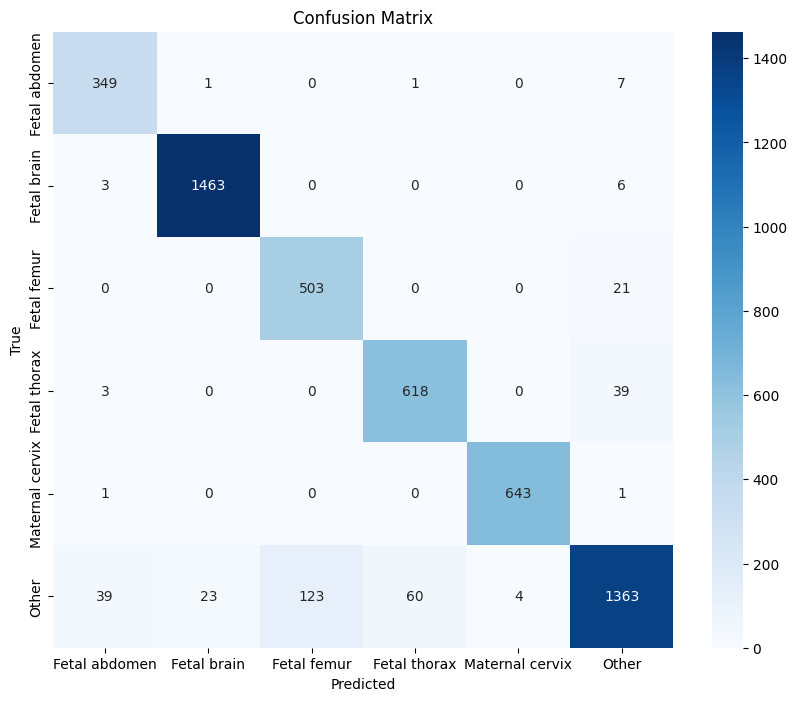

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [61]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
    
    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

In [17]:
for epoch in range(num_epochs):
    for model, optimizer in zip(models, optimizers):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate ensemble
    ensemble = EnsembleModel(models).to(device)
    val_loss, val_acc = evaluate(ensemble, test_loader, criterion, device)
    
    for scheduler in schedulers:
        scheduler.step(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Ensemble Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_ensemble_acc:
        best_ensemble_acc = val_acc
        torch.save(ensemble.state_dict(), 'best_ensemble_model.pth')
    
    print()

print(f"Best Ensemble Validation Accuracy: {best_ensemble_acc:.4f}")

Epoch 1/30
Ensemble Val Loss: 0.3794, Val Acc: 0.7610

Epoch 2/30
Ensemble Val Loss: 0.2276, Val Acc: 0.8634

Epoch 3/30
Ensemble Val Loss: 0.2351, Val Acc: 0.8628

Epoch 4/30
Ensemble Val Loss: 0.2246, Val Acc: 0.8699

Epoch 5/30
Ensemble Val Loss: 0.2396, Val Acc: 0.8699

Epoch 6/30
Ensemble Val Loss: 0.1925, Val Acc: 0.8949

Epoch 7/30
Ensemble Val Loss: 0.1730, Val Acc: 0.9057

Epoch 8/30
Ensemble Val Loss: 0.1392, Val Acc: 0.9275

Epoch 9/30
Ensemble Val Loss: 0.1520, Val Acc: 0.9161

Epoch 10/30
Ensemble Val Loss: 0.1649, Val Acc: 0.9167

Epoch 11/30
Ensemble Val Loss: 0.1529, Val Acc: 0.9241

Epoch 12/30
Ensemble Val Loss: 0.1369, Val Acc: 0.9266

Epoch 13/30
Ensemble Val Loss: 0.1347, Val Acc: 0.9332

Epoch 14/30
Ensemble Val Loss: 0.1476, Val Acc: 0.9290

Epoch 15/30
Ensemble Val Loss: 0.1491, Val Acc: 0.9205

Epoch 16/30
Ensemble Val Loss: 0.1372, Val Acc: 0.9334

Epoch 17/30
Ensemble Val Loss: 0.1512, Val Acc: 0.9292

Epoch 18/30
Ensemble Val Loss: 0.1441, Val Acc: 0.9330

E

In [62]:
def load_ensemble_model(model_path, device, num_classes):
    state_dict = torch.load(model_path, map_location=device)
    
    num_models = len([key for key in state_dict.keys() if key.startswith('models.0')])
    models = [FetalPlanesModel(num_classes) for _ in range(num_models)]
    ensemble = EnsembleModel(models)
    
    ensemble.load_state_dict(state_dict)
    ensemble.to(device)
    ensemble.eval()
    
    return ensemble

In [63]:
class DistilledModel(nn.Module):
    def __init__(self, num_classes):
        super(DistilledModel, self).__init__()
        
        self.densenet = densenet169(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.densenet(x)

In [58]:
def distill_model(teacher, student, train_loader, val_loader, num_epochs, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(student.parameters())
    
    for epoch in range(num_epochs):
        student.train()
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            
            with torch.no_grad():
                soft_targets = teacher(inputs)
            
            optimizer.zero_grad()
            outputs = student(inputs)
            loss = criterion(outputs, soft_targets)
            loss.backward()
            optimizer.step()
        
        student.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy:.4f}")
    
    return student

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 6 

ensemble = load_ensemble_model('/kaggle/working/best_ensemble_model.pth', device, num_classes)

distilled_model = DistilledModel(num_classes).to(device)

num_distill_epochs = 50 
distilled_model = distill_model(ensemble, distilled_model, train_loader, val_loader, num_distill_epochs, device)

torch.save(distilled_model.state_dict(), 'distilled_model.pth')

scripted_model = torch.jit.script(distilled_model)
torch.jit.save(scripted_model, 'distilled_model.pt')

# Hierarchical Classification

In [47]:
class HierarchicalFetalPlanesDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.copy()
        self.img_dir = img_dir
        self.transform = transform
        
        self.main_label_encoder = LabelEncoder()
        self.dataframe['Plane_encoded'] = self.main_label_encoder.fit_transform(self.dataframe['Plane'])
        
        self.brain_label_encoder = LabelEncoder()
        self.dataframe['Brain_plane_encoded'] = self.brain_label_encoder.fit_transform(self.dataframe['Brain_plane'])
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image_name'] + '.png'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        main_label = self.dataframe.iloc[idx]['Plane_encoded']
        brain_label = self.dataframe.iloc[idx]['Brain_plane_encoded']
        
        if self.transform:
            image = self.transform(image)
        
        return image, main_label, brain_label

# Create new datasets

In [48]:
train_dataset = HierarchicalFetalPlanesDataset(train_df, image_dir, transform=train_transform)
test_dataset = HierarchicalFetalPlanesDataset(test_df, image_dir, transform=test_transform)

# Create new data loaders

In [49]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [50]:
print(f"Number of main classes: {len(train_dataset.main_label_encoder.classes_)}")
print(f"Number of brain subclasses: {len(train_dataset.brain_label_encoder.classes_)}")

Number of main classes: 6
Number of brain subclasses: 5


In [51]:
class HierarchicalFetalPlanesModel(nn.Module):
    def __init__(self, num_main_classes, num_brain_subclasses):
        super(HierarchicalFetalPlanesModel, self).__init__()
        
        self.densenet = models.densenet169(pretrained=True)
        
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()
        
        self.main_classifier = nn.Linear(num_ftrs, num_main_classes)
        self.brain_classifier = nn.Linear(num_ftrs, num_brain_subclasses)

    def forward(self, x):
        features = self.densenet(x)
        main_output = self.main_classifier(features)
        brain_output = self.brain_classifier(features)
        return main_output, brain_output

# Instantiate the model

In [53]:
num_main_classes = len(train_dataset.main_label_encoder.classes_)
num_brain_subclasses = len(train_dataset.brain_label_encoder.classes_)
model = HierarchicalFetalPlanesModel(num_main_classes, num_brain_subclasses).to(device)

In [54]:
print(model)

HierarchicalFetalPlanesModel(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, e

In [55]:
class HierarchicalLoss(nn.Module):
    def __init__(self, main_weight=1.0, brain_weight=0.5):
        super(HierarchicalLoss, self).__init__()
        self.main_loss = nn.CrossEntropyLoss()
        self.brain_loss = nn.CrossEntropyLoss()
        self.main_weight = main_weight
        self.brain_weight = brain_weight

    def forward(self, main_output, brain_output, main_target, brain_target):
        main_loss = self.main_loss(main_output, main_target)
        
        brain_mask = (main_target == train_dataset.main_label_encoder.transform(['Fetal brain'])[0])
        if brain_mask.sum() > 0:
            brain_loss = self.brain_loss(brain_output[brain_mask], brain_target[brain_mask])
        else:
            brain_loss = 0
        
        return self.main_weight * main_loss + self.brain_weight * brain_loss

In [56]:
criterion = HierarchicalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    main_correct = 0
    brain_correct = 0
    total = 0
    brain_total = 0

    for inputs, main_labels, brain_labels in dataloader:
        inputs, main_labels, brain_labels = inputs.to(device), main_labels.to(device), brain_labels.to(device)

        optimizer.zero_grad()
        main_outputs, brain_outputs = model(inputs)
        loss = criterion(main_outputs, brain_outputs, main_labels, brain_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, main_predicted = main_outputs.max(1)
        _, brain_predicted = brain_outputs.max(1)
        total += main_labels.size(0)
        main_correct += main_predicted.eq(main_labels).sum().item()
        
        brain_mask = (main_labels == train_dataset.main_label_encoder.transform(['Fetal brain'])[0])
        brain_total += brain_mask.sum().item()
        brain_correct += brain_predicted[brain_mask].eq(brain_labels[brain_mask]).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    main_acc = main_correct / total
    brain_acc = brain_correct / brain_total if brain_total > 0 else 0
    return epoch_loss, main_acc, brain_acc

In [58]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    main_correct = 0
    brain_correct = 0
    total = 0
    brain_total = 0

    with torch.no_grad():
        for inputs, main_labels, brain_labels in dataloader:
            inputs, main_labels, brain_labels = inputs.to(device), main_labels.to(device), brain_labels.to(device)
            main_outputs, brain_outputs = model(inputs)
            loss = criterion(main_outputs, brain_outputs, main_labels, brain_labels)

            running_loss += loss.item() * inputs.size(0)
            _, main_predicted = main_outputs.max(1)
            _, brain_predicted = brain_outputs.max(1)
            total += main_labels.size(0)
            main_correct += main_predicted.eq(main_labels).sum().item()
            
            brain_mask = (main_labels == train_dataset.main_label_encoder.transform(['Fetal brain'])[0])
            brain_total += brain_mask.sum().item()
            brain_correct += brain_predicted[brain_mask].eq(brain_labels[brain_mask]).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    main_acc = main_correct / total
    brain_acc = brain_correct / brain_total if brain_total > 0 else 0
    return epoch_loss, main_acc, brain_acc

# Training Loop

In [59]:
num_epochs = 30
best_acc = 0.0

In [60]:
for epoch in range(num_epochs):
    train_loss, train_main_acc, train_brain_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_main_acc, val_brain_acc = evaluate(model, test_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Main Acc: {train_main_acc:.4f}, Train Brain Acc: {train_brain_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Main Acc: {val_main_acc:.4f}, Val Brain Acc: {val_brain_acc:.4f}")
    
    if val_main_acc > best_acc:
        best_acc = val_main_acc
        torch.save(model.state_dict(), 'best_hierarchical_model.pth')
    
    print()

print(f"Best Validation Main Accuracy: {best_acc:.4f}")

Epoch 1/30
Train Loss: 0.9178, Train Main Acc: 0.8402, Train Brain Acc: 0.6117
Val Loss: 0.8125, Val Main Acc: 0.8733, Val Brain Acc: 0.5557

Epoch 2/30
Train Loss: 0.6385, Train Main Acc: 0.9064, Train Brain Acc: 0.7167
Val Loss: 0.7020, Val Main Acc: 0.8941, Val Brain Acc: 0.7072

Epoch 3/30
Train Loss: 0.5426, Train Main Acc: 0.9229, Train Brain Acc: 0.7519
Val Loss: 0.8539, Val Main Acc: 0.8676, Val Brain Acc: 0.6114

Epoch 4/30
Train Loss: 0.4913, Train Main Acc: 0.9314, Train Brain Acc: 0.7753
Val Loss: 0.5769, Val Main Acc: 0.9203, Val Brain Acc: 0.7398

Epoch 5/30
Train Loss: 0.4550, Train Main Acc: 0.9360, Train Brain Acc: 0.7914
Val Loss: 0.6140, Val Main Acc: 0.8877, Val Brain Acc: 0.7697

Epoch 6/30
Train Loss: 0.4215, Train Main Acc: 0.9450, Train Brain Acc: 0.8105
Val Loss: 0.6247, Val Main Acc: 0.8776, Val Brain Acc: 0.7806

Epoch 7/30
Train Loss: 0.4002, Train Main Acc: 0.9449, Train Brain Acc: 0.8278
Val Loss: 0.6456, Val Main Acc: 0.8974, Val Brain Acc: 0.7004

Epoch 

# Load the best model


In [61]:
model.load_state_dict(torch.load('best_hierarchical_model.pth'))

<All keys matched successfully>

# Evaluate on test set

In [62]:
test_loss, test_main_acc, test_brain_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Main Acc: {test_main_acc:.4f}, Test Brain Acc: {test_brain_acc:.4f}")

Test Loss: 0.5042, Test Main Acc: 0.9308, Test Brain Acc: 0.7989


In [64]:
def predict(model, dataloader, device):
    model.eval()
    all_main_preds = []
    all_main_labels = []
    all_brain_preds = []
    all_brain_labels = []
    
    with torch.no_grad():
        for inputs, main_labels, brain_labels in dataloader:
            inputs = inputs.to(device)
            main_outputs, brain_outputs = model(inputs)
            _, main_preds = main_outputs.max(1)
            _, brain_preds = brain_outputs.max(1)
            
            all_main_preds.extend(main_preds.cpu().numpy())
            all_main_labels.extend(main_labels.numpy())
            all_brain_preds.extend(brain_preds.cpu().numpy())
            all_brain_labels.extend(brain_labels.numpy())
    
    return np.array(all_main_preds), np.array(all_main_labels), np.array(all_brain_preds), np.array(all_brain_labels)

# Get predictions

In [65]:
main_preds, main_labels, brain_preds, brain_labels = predict(model, test_loader, device)

# Main classification confusion matrix

In [66]:
main_cm = confusion_matrix(main_labels, main_preds)
main_class_names = train_dataset.main_label_encoder.classes_

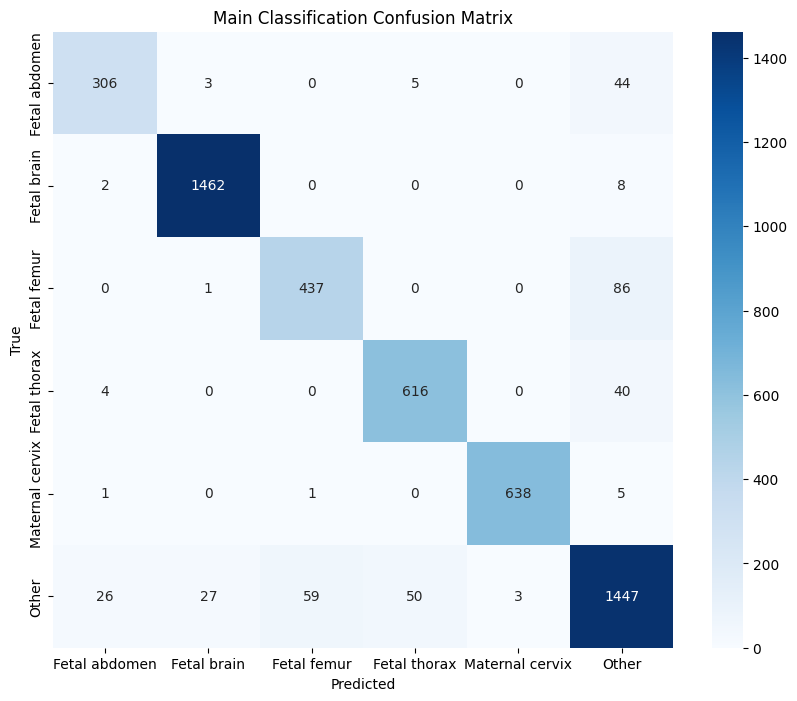

In [67]:
plt.figure(figsize=(10, 8))
sns.heatmap(main_cm, annot=True, fmt='d', cmap='Blues', xticklabels=main_class_names, yticklabels=main_class_names)
plt.title('Main Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Brain subclassification confusion matrix

In [68]:
brain_mask = (main_labels == train_dataset.main_label_encoder.transform(['Fetal brain'])[0])
brain_cm = confusion_matrix(brain_labels[brain_mask], brain_preds[brain_mask])
brain_class_names = train_dataset.brain_label_encoder.classes_

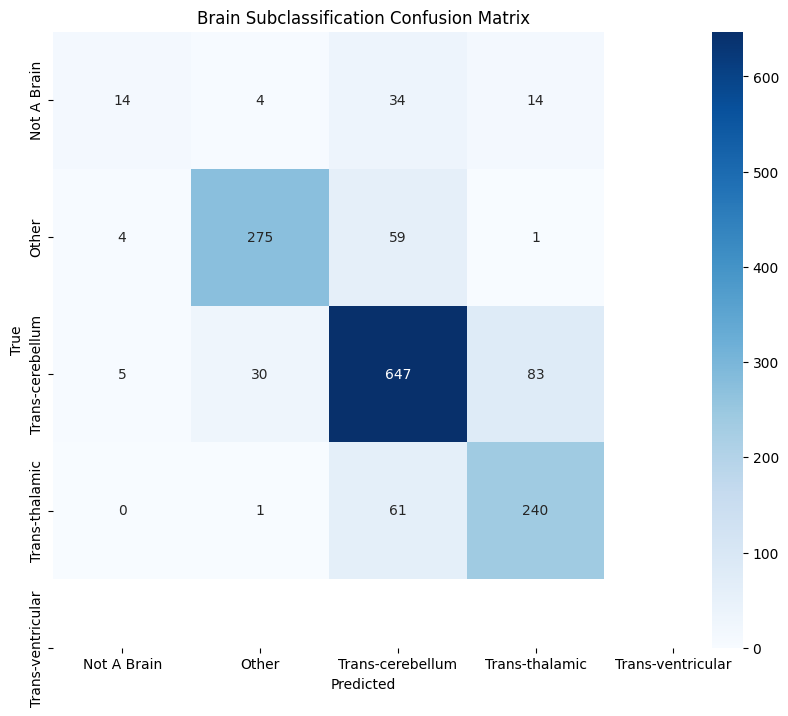

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(brain_cm, annot=True, fmt='d', cmap='Blues', xticklabels=brain_class_names, yticklabels=brain_class_names)
plt.title('Brain Subclassification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()